# 03 - Domain Shift Generation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IvanNece/Detection-of-Anomalies-with-Localization/blob/code_refactor/notebooks/03_domain_shift_generation.ipynb)


## Objectives
1. Tests and validates shift transformations
2. Generates the complete MVTec-Shift dataset by applying transforms to all splits
3. Saves transformed images and masks to `data/shifted/`

## Setup - Mount Drive & Configure Paths

In [ ]:
# Mount Drive and setup
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')

# Clone repository
!git clone -b code_refactor https://github.com/IvanNece/Detection-of-Anomalies-with-Localization.git 2>/dev/null || echo "Repository already exists"

PROJECT_ROOT = Path('/content/Detection-of-Anomalies-with-Localization')
DATASET_PATH = Path('/content/drive/MyDrive/mvtec_ad')

## Imports and Configurations

In [ ]:
import sys
import matplotlib.pyplot as plt
from PIL import Image
import torch

sys.path.insert(0, str(PROJECT_ROOT))

from src.utils.reproducibility import set_seed
from src.utils.config import Config
from src.data.transforms import get_clean_transforms, get_shift_transforms
from src.data.splitter import load_splits
from src.utils.utils import denormalize

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

In [3]:
config = Config.load(PROJECT_ROOT / 'configs' / 'experiment_config.yaml')
set_seed(config.seed)

print(f"Seed: {config.seed}")
print(f"Image size: {config.dataset.image_size}")
print(f"\nGeometric transforms: {config.domain_shift.geometric}")
print(f"\nPhotometric transforms: {config.domain_shift.photometric}")

Loaded configuration from /content/Detection-of-Anomalies-with-Localization/configs/experiment_config.yaml
Random seed set to 42 for reproducibility
Seed: 42
Image size: 224

Geometric transforms: Config({'rotation_range': [-10, 10], 'scale_range': [0.9, 1.0], 'aspect_ratio_range': [0.9, 1.1], 'translate_range': 0.1})

Photometric transforms: Config({'brightness_range': [0.7, 1.3], 'contrast_range': [0.7, 1.3], 'saturation_range': [0.7, 1.3], 'gaussian_blur': {'kernel_size': [3, 5], 'sigma_range': [0.1, 2.0]}, 'gaussian_noise': {'sigma_range': [0.01, 0.05]}})


## 1. Load Test Images

In [4]:
# Load splits
splits = load_splits(PROJECT_ROOT / 'data' / 'processed' / 'clean_splits.json')

# Get sample images: one normal and one anomalous from hazelnut test set
hazelnut_test = splits['hazelnut']['test']

# Find a normal image
normal_idx = [i for i, label in enumerate(hazelnut_test['labels']) if label == 0][0]
normal_img_path = hazelnut_test['images'][normal_idx]

# Find an anomalous image with mask (not None)
anomalous_indices = [i for i, (label, mask) in enumerate(zip(hazelnut_test['labels'], hazelnut_test['masks']))
                     if label == 1 and mask is not None]
if not anomalous_indices:
    print("Warning: No anomalous images with masks found, using first anomaly")
    anomalous_idx = [i for i, label in enumerate(hazelnut_test['labels']) if label == 1][0]
else:
    anomalous_idx = anomalous_indices[0]

anomalous_img_path = hazelnut_test['images'][anomalous_idx]
anomalous_mask_path = hazelnut_test['masks'][anomalous_idx]

print(f"Normal image: {Path(normal_img_path).name}")
print(f"Anomalous image: {Path(anomalous_img_path).name}")
print(f"Mask: {Path(anomalous_mask_path).name if anomalous_mask_path else 'None'}")


Normal image: 000.png
Anomalous image: 007.png
Mask: 007_mask.png


## 2. Test Clean vs Shift Transforms

In [ ]:
# Create transforms
clean_transform = get_clean_transforms(
    image_size=config.dataset.image_size,
    normalize_mean=config.dataset.normalize.mean,
    normalize_std=config.dataset.normalize.std
)

shift_transform = get_shift_transforms(
    image_size=config.dataset.image_size,
    normalize_mean=config.dataset.normalize.mean,
    normalize_std=config.dataset.normalize.std,
    geometric_config=config.domain_shift.geometric.to_dict(),
    photometric_config={
        **config.domain_shift.photometric.to_dict(),
        'illumination': config.domain_shift.illumination.to_dict()
    },
    seed=config.seed
)

## 3. Visualize: Normal Image (Clean vs Shifted)

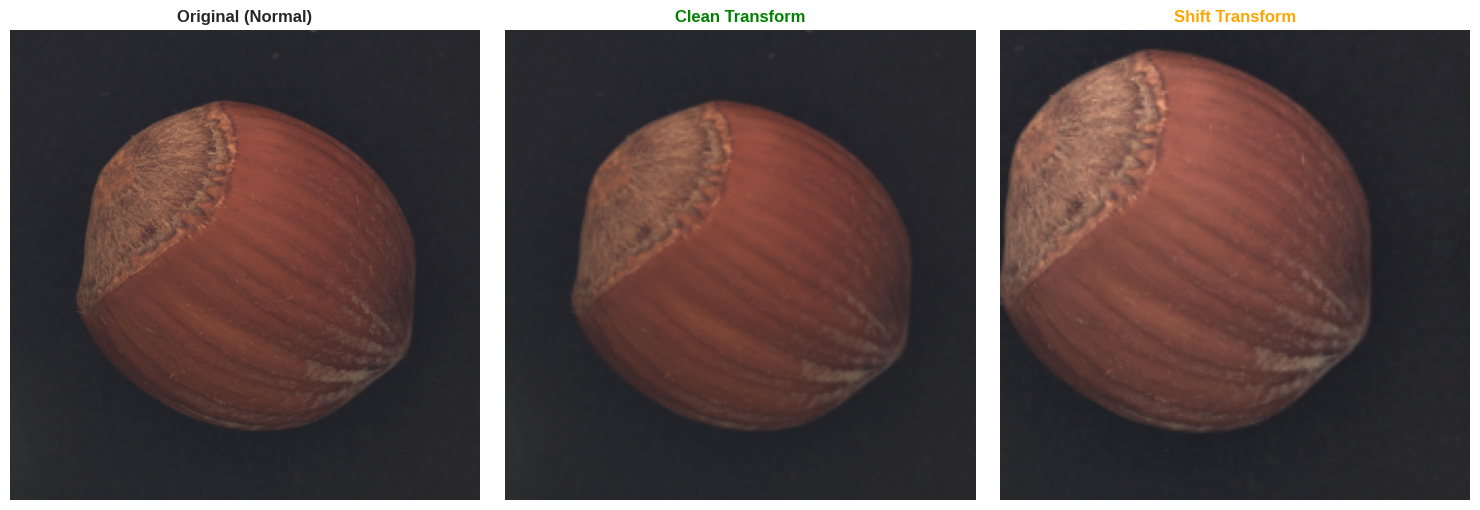

Notice the differences in: brightness, rotation, blur


In [ ]:
# Load normal image
normal_img = Image.open(normal_img_path).convert('RGB')

# Apply transforms
normal_clean, _ = clean_transform(normal_img, None)
normal_shifted, _ = shift_transform(normal_img, None)

# Denormalize for visualization
normal_clean_vis = denormalize(normal_clean, config.dataset.normalize.mean, config.dataset.normalize.std)
normal_shifted_vis = denormalize(normal_shifted, config.dataset.normalize.mean, config.dataset.normalize.std)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(normal_img)
axes[0].set_title('Original (Normal)', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(normal_clean_vis.permute(1, 2, 0).numpy())
axes[1].set_title('Clean Transform', fontsize=12, fontweight='bold', color='green')
axes[1].axis('off')

axes[2].imshow(normal_shifted_vis.permute(1, 2, 0).numpy())
axes[2].set_title('Shift Transform', fontsize=12, fontweight='bold', color='orange')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 4. Visualize: Anomalous Image with Mask Alignment

In [ ]:
# Load anomalous image and mask
anomalous_img = Image.open(anomalous_img_path).convert('RGB')
if anomalous_mask_path:
    anomalous_mask = Image.open(anomalous_mask_path).convert('L')
else:
    # Create empty mask if None
    anomalous_mask = Image.new('L', anomalous_img.size, 0)
    print("Note: No mask found, using empty mask for visualization")

# Apply transforms
anom_clean, mask_clean = clean_transform(anomalous_img, anomalous_mask)
anom_shifted, mask_shifted = shift_transform(anomalous_img, anomalous_mask)

# Denormalize
anom_clean_vis = denormalize(anom_clean, config.dataset.normalize.mean, config.dataset.normalize.std)
anom_shifted_vis = denormalize(anom_shifted, config.dataset.normalize.mean, config.dataset.normalize.std)

# Plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Images
axes[0, 0].imshow(anomalous_img)
axes[0, 0].set_title('Original (Anomalous)', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(anom_clean_vis.permute(1, 2, 0).numpy())
axes[0, 1].set_title('Clean Transform', fontsize=12, fontweight='bold', color='green')
axes[0, 1].axis('off')

axes[0, 2].imshow(anom_shifted_vis.permute(1, 2, 0).numpy())
axes[0, 2].set_title('Shift Transform', fontsize=12, fontweight='bold', color='orange')
axes[0, 2].axis('off')

# Row 2: Masks
axes[1, 0].imshow(anomalous_mask, cmap='gray')
axes[1, 0].set_title('Original Mask', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(mask_clean.squeeze().numpy(), cmap='gray')
axes[1, 1].set_title('Clean Mask', fontsize=12, fontweight='bold', color='green')
axes[1, 1].axis('off')

axes[1, 2].imshow(mask_shifted.squeeze().numpy(), cmap='gray')
axes[1, 2].set_title('Shift Mask', fontsize=12, fontweight='bold', color='orange')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## 5. Test Reproducibility

In [ ]:
# Apply shift transform twice with same seed
shift_transform_1 = get_shift_transforms(
    image_size=config.dataset.image_size,
    normalize_mean=config.dataset.normalize.mean,
    normalize_std=config.dataset.normalize.std,
    geometric_config=config.domain_shift.geometric.to_dict(),
    photometric_config={
        **config.domain_shift.photometric.to_dict(),
        'illumination': config.domain_shift.illumination.to_dict()
    },
    seed=42
)

shift_transform_2 = get_shift_transforms(
    image_size=config.dataset.image_size,
    normalize_mean=config.dataset.normalize.mean,
    normalize_std=config.dataset.normalize.std,
    geometric_config=config.domain_shift.geometric.to_dict(),
    photometric_config={
        **config.domain_shift.photometric.to_dict(),
        'illumination': config.domain_shift.illumination.to_dict()
    },
    seed=42
)

img1, mask1 = shift_transform_1(anomalous_img, anomalous_mask)
img2, mask2 = shift_transform_2(anomalous_img, anomalous_mask)

# Check if tensors are identical
img_match = torch.allclose(img1, img2, atol=1e-6)
mask_match = torch.allclose(mask1, mask2, atol=1e-6)

print(f"Image reproducibility: {'OK' if img_match else 'X'}")
print(f"Mask reproducibility: {'OK' if mask_match else 'X'}")

## 6. Test Non-Uniform Illumination Transform

In [ ]:
# Print illumination configuration
print("Non-Uniform Illumination Configuration:")
print("=" * 70)
print(f"  Enabled: {config.domain_shift.illumination.enabled}")
print(f"  Type: {config.domain_shift.illumination.type}")
print(f"  Direction: {config.domain_shift.illumination.direction}")
print(f"  Strength Range: {config.domain_shift.illumination.strength_range}")
print(f"  Probability: {config.domain_shift.illumination.probability} (50% of shifted images)")
print(f"  Smooth Sigma: {config.domain_shift.illumination.smooth_sigma}")
print("=" * 70)

Non-Uniform Illumination Configuration:
  Enabled: True
  Type: linear
  Direction: random
  Strength Range: [0.4, 0.7]
  Probability: 0.5 (50% of shifted images)
  Smooth Sigma: 80

Based on MVTec AD 2 paper:
  - Linear gradients simulate spotlight from side (Fabric, Wall Plugs)
  - Radial gradients simulate center/edge lighting (Vial)
  - Strength [0.4, 0.7] = 40-70% brightness reduction on dark edge


Based on MVTec AD 2 paper:
- Linear gradients simulate spotlight from side (Fabric, Wall Plugs)
- Radial gradients simulate center/edge lighting (Vial)
- Strength [0.4, 0.7] = 40-70% brightness reduction on dark edge

In [ ]:
# Demonstrate different illumination types with seed 42
test_img = Image.open(anomalous_img_path).convert('RGB')

# Create figure for comparison (2 rows, 4 columns)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Original
axes[0, 0].imshow(test_img)
axes[0, 0].set_title('Original', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

# Linear gradients - different directions (seed 42 + offset for variety)
directions = ['left', 'right', 'top']
for idx, direction in enumerate(directions):
    illum_config = config.domain_shift.illumination.to_dict()
    illum_config['direction'] = direction
    illum_config['probability'] = 1.0  # Always apply for visualization

    transform = get_shift_transforms(
        image_size=config.dataset.image_size,
        normalize_mean=config.dataset.normalize.mean,
        normalize_std=config.dataset.normalize.std,
        geometric_config={'rotation_range': [0, 0], 'scale_range': [1.0, 1.0], 'translate_range': 0.0},
        photometric_config={
            'brightness_range': [1.0, 1.0],
            'contrast_range': [1.0, 1.0],
            'saturation_range': [1.0, 1.0],
            'gaussian_blur': {'kernel_size': [3], 'sigma_range': [0.1, 0.1]},  # Fixed: avoid sigma=0
            'gaussian_noise': {'sigma_range': [0.0, 0.0]},
            'illumination': illum_config
        },
        seed=42 + idx
    )

    img_transformed, _ = transform(test_img, None)
    img_vis = denormalize(img_transformed, config.dataset.normalize.mean, config.dataset.normalize.std)

    axes[0, idx + 1].imshow(img_vis.permute(1, 2, 0).numpy())
    axes[0, idx + 1].set_title(f'Linear: {direction.capitalize()}', fontsize=11, fontweight='bold', color='orange')
    axes[0, idx + 1].axis('off')

# Radial gradient
illum_config_radial = config.domain_shift.illumination.to_dict()
illum_config_radial['type'] = 'radial'
illum_config_radial['probability'] = 1.0

transform_radial = get_shift_transforms(
    image_size=config.dataset.image_size,
    normalize_mean=config.dataset.normalize.mean,
    normalize_std=config.dataset.normalize.std,
    geometric_config={'rotation_range': [0, 0], 'scale_range': [1.0, 1.0], 'translate_range': 0.0},
    photometric_config={
        'brightness_range': [1.0, 1.0],
        'contrast_range': [1.0, 1.0],
        'saturation_range': [1.0, 1.0],
        'gaussian_blur': {'kernel_size': [3], 'sigma_range': [0.1, 0.1]},  # Fixed: avoid sigma=0
        'gaussian_noise': {'sigma_range': [0.0, 0.0]},
        'illumination': illum_config_radial
    },
    seed=42 + 100
)

img_radial, _ = transform_radial(test_img, None)
img_radial_vis = denormalize(img_radial, config.dataset.normalize.mean, config.dataset.normalize.std)

axes[1, 0].imshow(img_radial_vis.permute(1, 2, 0).numpy())
axes[1, 0].set_title('Radial Gradient', fontsize=11, fontweight='bold', color='purple')
axes[1, 0].axis('off')

# Full shift with illumination (seed 42)
shift_full = get_shift_transforms(
    image_size=config.dataset.image_size,
    normalize_mean=config.dataset.normalize.mean,
    normalize_std=config.dataset.normalize.std,
    geometric_config=config.domain_shift.geometric.to_dict(),
    photometric_config={
        **config.domain_shift.photometric.to_dict(),
        'illumination': {**config.domain_shift.illumination.to_dict(), 'probability': 1.0}
    },
    seed=42
)

img_full, _ = shift_full(test_img, None)
img_full_vis = denormalize(img_full, config.dataset.normalize.mean, config.dataset.normalize.std)

axes[1, 1].imshow(img_full_vis.permute(1, 2, 0).numpy())
axes[1, 1].set_title('Full Shift + Illumination\n(All transforms, seed=42)', fontsize=11, fontweight='bold', color='red')
axes[1, 1].axis('off')

# Hide empty subplots
axes[1, 2].axis('off')
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()

**Illumination types demonstrated:**
    - **Linear gradients**: Spotlight from side (like MVTec AD 2 Fabric, Wall Plugs)
    - **Radial gradients**: Center/edge lighting (like MVTec AD 2 Vial)
    - **Full shift**: Combines all transforms (rotation, color, blur, noise, illumination)

**All transforms use seed 42 for perfect reproducibility**

## 7. Multiple Shift Examples

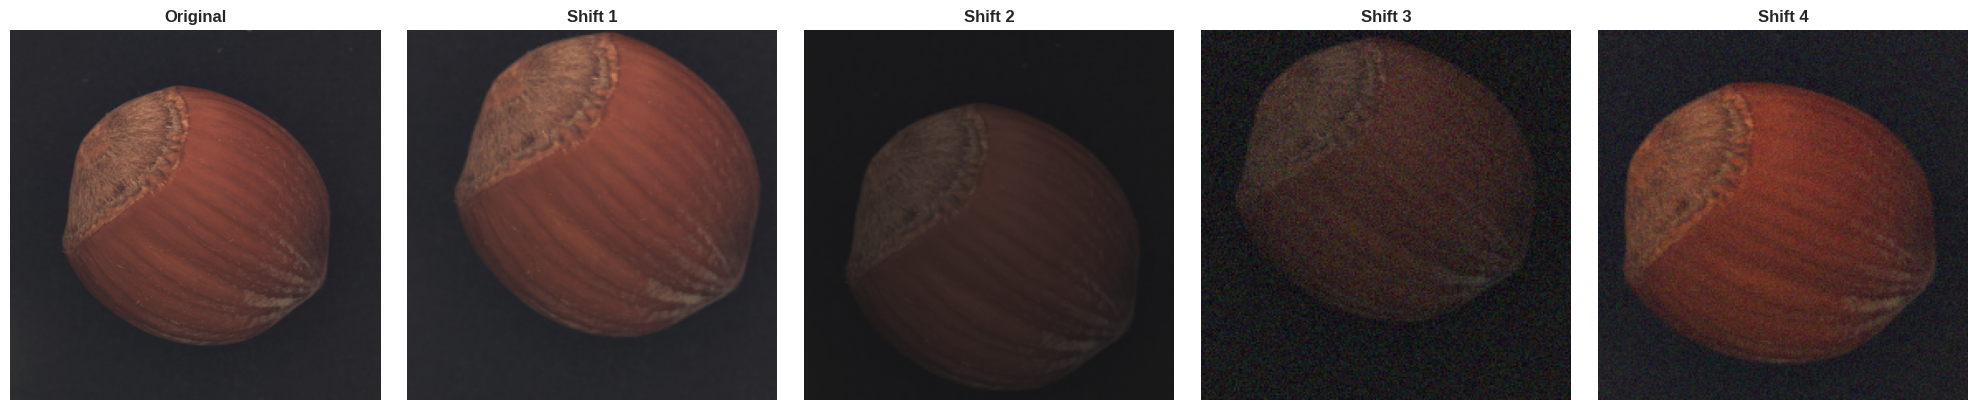

Each shift produces different but realistic variations
Transforms applied: rotation, scale, color, blur, noise, illumination (p=0.5)


In [ ]:
# Generate multiple shifted versions with different seeds
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

axes[0].imshow(normal_img)
axes[0].set_title('Original', fontsize=12, fontweight='bold')
axes[0].axis('off')

for i in range(1, 5):
    shift_t = get_shift_transforms(
        image_size=config.dataset.image_size,
        normalize_mean=config.dataset.normalize.mean,
        normalize_std=config.dataset.normalize.std,
        geometric_config=config.domain_shift.geometric.to_dict(),
        photometric_config={
            **config.domain_shift.photometric.to_dict(),
            'illumination': config.domain_shift.illumination.to_dict()
        },
        seed=42 + i
    )
    img_shifted, _ = shift_t(normal_img, None)
    img_shifted_vis = denormalize(img_shifted, config.dataset.normalize.mean, config.dataset.normalize.std)

    axes[i].imshow(img_shifted_vis.permute(1, 2, 0).numpy())
    axes[i].set_title(f'Shift {i}', fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

- Each shift produces different but realistic variations
- Transforms applied: rotation, scale, color, blur, noise, illumination (p=0.5)

## 8. Create Output Directory Structure

Create directory structure for MVTec-Shift to save both locally and in Google Drive.

In [ ]:
from tqdm.auto import tqdm

# Define shifted dataset path
SHIFTED_PATH = PROJECT_ROOT / 'data' / 'shifted'

for class_name in config.dataset.classes:
    for split in ['train', 'val', 'test']:
        # Images directory
        img_dir = SHIFTED_PATH / class_name / split / 'images'
        img_dir.mkdir(parents=True, exist_ok=True)

        # Masks directory
        mask_dir = SHIFTED_PATH / class_name / split / 'masks'
        mask_dir.mkdir(parents=True, exist_ok=True)


## 9. Generate Shifted Dataset - Apply Transforms to All Images

In [ ]:
from PIL import Image
import numpy as np

# Helper function to extract subfolder from path
def get_subfolder_from_path(img_path, class_name):
    """
    Extract subfolder identifier from image path.

    Examples:
        data/raw/mvtec_ad/carpet/test/color/001.png -> test_color
        data/raw/mvtec_ad/carpet/train/good/001.png -> train_good
        data/raw/mvtec_ad/hazelnut/test/crack/001.png -> test_crack
    """
    img_path = Path(img_path)

    # Get parts after class_name
    parts = img_path.parts

    # Find the index of class_name in the path parts
    try:
        class_idx = parts.index(class_name)
    except ValueError:
        # If class_name not found, try lowercase/uppercase variations
        for i, part in enumerate(parts):
            if part.lower() == class_name.lower():
                class_idx = i
                break
        else:
            # Fallback: assume standard structure and search backwards
            # Path should be like: .../class_name/split/subfolder/image.png
            class_idx = len(parts) - 4

    # Get the two folders after class_name (e.g., ['test', 'color'] or ['train', 'good'])
    folder1 = parts[class_idx + 1]  # 'test' or 'train'
    folder2 = parts[class_idx + 2]  # 'color', 'good', 'crack', etc.

    return f"{folder1}_{folder2}"

# Helper function to apply transforms and get PIL images (not normalized tensors)
def apply_shift_and_save(img_pil, mask_pil, seed_val, config):
    """
    Apply shift transforms and return PIL images ready to save.

    This creates a temporary transform pipeline that applies all geometric and photometric
    transforms but returns denormalized images instead of normalized tensors.
    """

    temp_transform = get_shift_transforms(
        image_size=config.dataset.image_size,
        normalize_mean=config.dataset.normalize.mean,
        normalize_std=config.dataset.normalize.std,
        geometric_config=config.domain_shift.geometric.to_dict(),
        photometric_config={
            **config.domain_shift.photometric.to_dict(),
            'illumination': config.domain_shift.illumination.to_dict()
        },
        seed=seed_val
    )

    # Apply transform
    img_tensor, mask_tensor = temp_transform(img_pil, mask_pil)

    # Denormalize image tensor back to [0, 1] range
    img_denorm = denormalize(img_tensor, config.dataset.normalize.mean, config.dataset.normalize.std)

    # Convert to PIL
    img_denorm_np = (img_denorm.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    img_pil_out = Image.fromarray(img_denorm_np)

    # Convert mask tensor to PIL
    if mask_tensor is not None:
        mask_np = (mask_tensor.squeeze().numpy() * 255).astype(np.uint8)
        mask_pil_out = Image.fromarray(mask_np, mode='L')
    else:
        mask_pil_out = None

    return img_pil_out, mask_pil_out


# Initialize shifted splits dictionary
shifted_splits = {}
total_images = 0
total_masks = 0

print("Generating MVTec-Shift dataset...")
print("=" * 70)
print(f"Using seed: {config.seed} (incremental per image for variety)")
print(f"Transforms: geometric + photometric + illumination (p={config.domain_shift.illumination.probability})")
print("=" * 70)

for class_name in config.dataset.classes:
    print(f"\n{'='*70}")
    print(f"Processing class: {class_name.upper()}")
    print('='*70)
    shifted_splits[class_name] = {}

    for split in ['train', 'val', 'test']:
        print(f"\n  Split: {split}")

        # Get original split data
        original_split = splits[class_name][split]
        n_images = len(original_split['images'])

        # Initialize lists for shifted split
        shifted_images = []
        shifted_masks = []
        shifted_labels = original_split['labels'].copy()

        # Process each image with progress bar
        for idx in tqdm(range(n_images), desc=f"    Transforming", leave=False):
            img_path = original_split['images'][idx]
            mask_path = original_split['masks'][idx]
            label = original_split['labels'][idx]

            # Load original image
            img = Image.open(img_path).convert('RGB')

            # Load mask if exists (anomalous samples)
            if mask_path:
                mask = Image.open(mask_path).convert('L')
            else:
                mask = None

            # Get original filename and create shifted filename
            img_name = Path(img_path).stem  # Without extension

            subfolder = get_subfolder_from_path(img_path, class_name)

            # Create shifted filename with subfolder identifier
            # Example: 001.png from carpet/test/color to 001_shifted_test_color.png
            shifted_img_name = f"{img_name}_shifted_{subfolder}.png"

            # Apply shift transform with reproducible seed (base_seed + global_image_index)
            # This ensures variety across images while maintaining reproducibility
            seed_offset = total_images + idx
            img_shifted_pil, mask_shifted_pil = apply_shift_and_save(
                img, mask, config.seed + seed_offset, config
            )

            # Save shifted image
            shifted_img_path = SHIFTED_PATH / class_name / split / 'images' / shifted_img_name
            img_shifted_pil.save(shifted_img_path)
            shifted_images.append(str(shifted_img_path))

            # Save shifted mask (if exists)
            if mask_shifted_pil:
                shifted_mask_name = f"{img_name}_shifted_{subfolder}.png"
                shifted_mask_path = SHIFTED_PATH / class_name / split / 'masks' / shifted_mask_name
                mask_shifted_pil.save(shifted_mask_path)
                shifted_masks.append(str(shifted_mask_path))
                total_masks += 1
            else:
                shifted_masks.append(None)

        # Store shifted split
        shifted_splits[class_name][split] = {
            'images': shifted_images,
            'masks': shifted_masks,
            'labels': shifted_labels
        }

        total_images += n_images

        print(f"      {n_images} images transformed and saved")
        print(f"      Images: {len([m for m in shifted_masks if m is not None])} with masks, {len([m for m in shifted_masks if m is None])} without")

print("\n" + "=" * 70)
print(f"MVTec-Shift generation complete!")
print(f"  Total images: {total_images}")
print(f"  Total masks: {total_masks}")
print("=" * 70)

## 10. Save Shifted Splits to JSON

In [ ]:
from src.data.splitter import save_splits

# Save shifted splits
shifted_splits_path = PROJECT_ROOT / 'data' / 'processed' / 'shifted_splits.json'

save_splits(
    splits=shifted_splits,
    output_path=shifted_splits_path,
    metadata={
        'domain': 'shifted',
        'seed': config.seed,
        'seed_strategy': 'incremental (base_seed + image_index for variety)',
        'image_size': config.dataset.image_size,
        'transforms': {
            'geometric': config.domain_shift.geometric.to_dict(),
            'photometric': config.domain_shift.photometric.to_dict(),
            'illumination': config.domain_shift.illumination.to_dict()
        },
        'source_splits': 'clean_splits.json',
        'naming_convention': 'original_name_shifted.png'
    }
)

Splits saved to /content/Detection-of-Anomalies-with-Localization/data/processed/shifted_splits.json
✓ Shifted splits saved to: /content/Detection-of-Anomalies-with-Localization/data/processed/shifted_splits.json
  File size: 224.06 KB


## 11. Verify Generated Dataset

Verify MVTec-Shift dataset structure

In [ ]:
total_size = 0

for class_name in config.dataset.classes:
    print(f"\n{class_name.upper()}:")

    for split in ['train', 'val', 'test']:
        img_dir = SHIFTED_PATH / class_name / split / 'images'
        mask_dir = SHIFTED_PATH / class_name / split / 'masks'

        n_images = len(list(img_dir.glob('*.png'))) if img_dir.exists() else 0
        n_masks = len(list(mask_dir.glob('*.png'))) if mask_dir.exists() else 0

        # Calculate size
        if img_dir.exists():
            split_size = sum(f.stat().st_size for f in img_dir.glob('*.png'))
            if mask_dir.exists():
                split_size += sum(f.stat().st_size for f in mask_dir.glob('*.png'))
            total_size += split_size
        else:
            split_size = 0

        print(f"  {split:5s}: {n_images:3d} images, {n_masks:3d} masks ({split_size / (1024*1024):.1f} MB)")

print("\n" + "=" * 60)
print(f"Total dataset size: {total_size / (1024*1024):.1f} MB")

Verifying MVTec-Shift dataset structure...

HAZELNUT:
  train: 312 images,   0 masks (21.6 MB)
  val  : 100 images,  21 masks (6.9 MB)
  test :  89 images,  49 masks (6.4 MB)

CARPET:
  train: 224 images,   0 masks (22.1 MB)
  val  :  82 images,  26 masks (8.1 MB)
  test :  91 images,  63 masks (9.0 MB)

ZIPPER:
  train: 192 images,   0 masks (13.2 MB)
  val  :  83 images,  35 masks (5.8 MB)
  test : 116 images,  84 masks (7.7 MB)

✓ Total dataset size: 100.8 MB
✓ All files verified!


## 12. Visualize Original vs Shifted Comparison

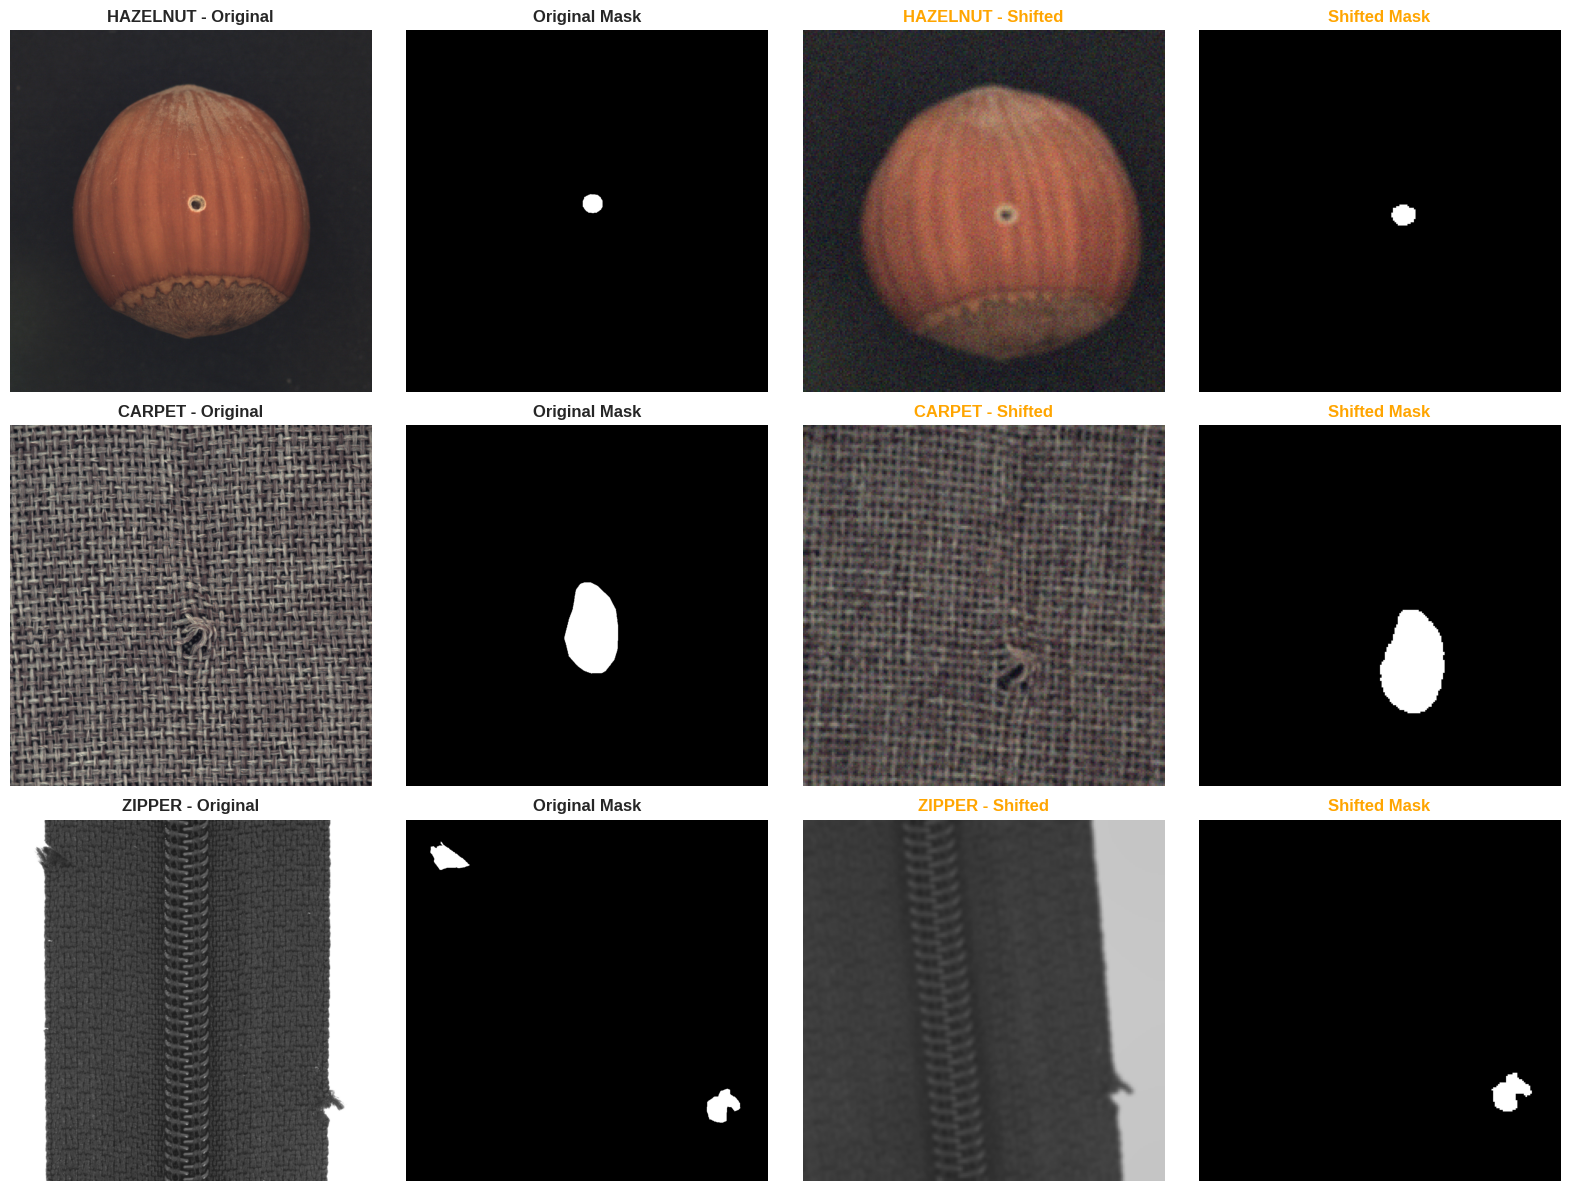

✓ Visual comparison shows domain shift effects on all classes


In [ ]:
# Compare original vs shifted for a few samples
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

sample_count = 0
for class_idx, class_name in enumerate(config.dataset.classes):
    # Get one test sample (anomalous if possible)
    test_split = splits[class_name]['test']

    # Find anomalous sample
    anom_indices = [i for i, l in enumerate(test_split['labels']) if l == 1]
    if anom_indices:
        idx = anom_indices[0]
    else:
        idx = 0

    # Load original
    orig_img_path = test_split['images'][idx]
    orig_mask_path = test_split['masks'][idx]

    orig_img = Image.open(orig_img_path).convert('RGB')
    if orig_mask_path:
        orig_mask = Image.open(orig_mask_path).convert('L')
    else:
        orig_mask = Image.new('L', orig_img.size, 0)

    # Load shifted
    shifted_split = shifted_splits[class_name]['test']
    shifted_img_path = shifted_split['images'][idx]
    shifted_mask_path = shifted_split['masks'][idx]

    shifted_img = Image.open(shifted_img_path).convert('RGB')
    if shifted_mask_path:
        shifted_mask = Image.open(shifted_mask_path).convert('L')
    else:
        shifted_mask = Image.new('L', shifted_img.size, 0)

    # Plot
    axes[class_idx, 0].imshow(orig_img)
    axes[class_idx, 0].set_title(f'{class_name.upper()} - Original', fontweight='bold')
    axes[class_idx, 0].axis('off')

    axes[class_idx, 1].imshow(orig_mask, cmap='gray')
    axes[class_idx, 1].set_title('Original Mask', fontweight='bold')
    axes[class_idx, 1].axis('off')

    axes[class_idx, 2].imshow(shifted_img)
    axes[class_idx, 2].set_title(f'{class_name.upper()} - Shifted', fontweight='bold', color='orange')
    axes[class_idx, 2].axis('off')

    axes[class_idx, 3].imshow(shifted_mask, cmap='gray')
    axes[class_idx, 3].set_title('Shifted Mask', fontweight='bold', color='orange')
    axes[class_idx, 3].axis('off')

plt.tight_layout()
plt.show()

## 13. Dataset Statistics Summary

In [ ]:
import pandas as pd

# Create statistics table
stats_data = []

for class_name in config.dataset.classes:
    for split in ['train', 'val', 'test']:
        split_data = shifted_splits[class_name][split]

        n_total = len(split_data['images'])
        n_normal = sum(1 for l in split_data['labels'] if l == 0)
        n_anomalous = sum(1 for l in split_data['labels'] if l == 1)
        n_masks = sum(1 for m in split_data['masks'] if m is not None)

        stats_data.append({
            'Class': class_name,
            'Split': split,
            'Total': n_total,
            'Normal': n_normal,
            'Anomalous': n_anomalous,
            'Masks': n_masks
        })

stats_df = pd.DataFrame(stats_data)

print("MVTec-Shift Dataset Statistics:")
print("=" * 70)
print(stats_df.to_string(index=False))
print("=" * 70)

# Summary by split
print("\nSummary by Split:")
summary = stats_df.groupby('Split')[['Total', 'Normal', 'Anomalous', 'Masks']].sum()
print(summary)

print(f"\nTotal images in MVTec-Shift: {stats_df['Total'].sum()}")

MVTec-Shift Dataset Statistics:
   Class Split  Total  Normal  Anomalous  Masks
hazelnut train    312     312          0      0
hazelnut   val    100      79         21     21
hazelnut  test     89      40         49     49
  carpet train    224     224          0      0
  carpet   val     82      56         26     26
  carpet  test     91      28         63     63
  zipper train    192     192          0      0
  zipper   val     83      48         35     35
  zipper  test    116      32         84     84

Summary by Split:
       Total  Normal  Anomalous  Masks
Split                                 
test     296     100        196    196
train    728     728          0      0
val      265     183         82     82

✓ Total images in MVTec-Shift: 1289


## 14. Save to Google Drive

In [ ]:
# Backup shifted dataset to Google Drive
import shutil

BACKUP_DIR = Path('/content/drive/MyDrive/mvtec_shift_backup')
BACKUP_DIR.mkdir(parents=True, exist_ok=True)

print("Backing up MVTec-Shift dataset to Google Drive...")
print(f"Source: {SHIFTED_PATH}")
print(f"Destination: {BACKUP_DIR}")
print("\nThis may take a few minutes...")

# Copy shifted splits JSON
shutil.copy2(shifted_splits_path, BACKUP_DIR / 'shifted_splits.json')
print("shifted_splits.json copied")

# Create zip of shifted dataset
zip_path = BACKUP_DIR / 'mvtec_shifted_dataset'
shutil.make_archive(str(zip_path), 'zip', str(SHIFTED_PATH))
print(f"Dataset zipped: {zip_path}.zip")

zip_size = (BACKUP_DIR / 'mvtec_shifted_dataset.zip').stat().st_size / (1024*1024)
print(f"\nBackup complete! Size: {zip_size:.1f} MB")

Backing up MVTec-Shift dataset to Google Drive...
Source: /content/Detection-of-Anomalies-with-Localization/data/shifted
Destination: /content/drive/MyDrive/mvtec_shift_backup

This may take a few minutes...
✓ shifted_splits.json copied
✓ Dataset zipped: /content/drive/MyDrive/mvtec_shift_backup/mvtec_shifted_dataset.zip

✓ Backup complete! Size: 101.0 MB
✓ Location: /content/drive/MyDrive/mvtec_shift_backup
